# Mentions

## Data prep

### Load the data and count.

In [1]:
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import load_tweet_df, tweet_type

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Simply the tweet on load
def mention_transform(tweet):
    mentions = []
    if 'retweeted_status' not in tweet and 'quoted_status' not in tweet:
        for mention in tweet.get('entities', {}).get('user_mentions', []):
            mentions.append({
                'tweet_id': tweet['id_str'],
                'user_id': tweet['user']['id_str'],
                'screen_name': tweet['user']['screen_name'],
                'mention_user_id': mention['id_str'],
                'mention_screen_name': mention['screen_name'],
                'tweet_created_at': date_parse(tweet['created_at'])
            })
    return mentions

mention_df = load_tweet_df(mention_transform, ['tweet_id', 'user_id', 'screen_name', 'mention_user_id',
                                           'mention_screen_name', 'tweet_created_at'])


INFO:root:Loading from tweets/6eea2088e010437da4b6031c2abffdc9_001.json.gz
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
INFO:root:Loading from tweets/a7bcdbde7a104285b92fe26e286f2543_001.json.gz
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000
DEBUG:root:Loaded 500000
DEBUG:root:Loaded 550000
DEBUG:root:Loaded 600000
INFO:root:Loading from tweets/e1c824ff2b3c4c5a9a93a16e5036d09a_001.json.gz
DEBUG:root:Loaded 650000
DEBUG:root:Loaded 700000
DEBUG:root:Loaded 750000


### Number of mentions found in the dataset

In [2]:
mention_df[['mention_user_id']].count()

mention_user_id    189213
dtype: int64

### The mention data
Each mention consists of the tweet id, the screen name and user id that is mentioned,
and the screen_name and user_id that is mentioning.

In [3]:
mention_df.head()

,tweet_id,user_id,screen_name,mention_user_id,mention_screen_name,tweet_created_at
0,847428582821449730,780221130,loren_duggan,140286364,nielslesniewski,2017-03-30 12:41:33+00:00
1,847086500944777220,285772181,akesslerdc,104851609,BrianToddCNN,2017-03-29 14:02:14+00:00
2,845466584625885184,285772181,akesslerdc,17178161,JamesVGrimaldi,2017-03-25 02:45:16+00:00
3,845377611165552640,285772181,akesslerdc,25073877,realDonaldTrump,2017-03-24 20:51:43+00:00
4,845376332011913217,285772181,akesslerdc,822215679726100480,POTUS,2017-03-24 20:46:38+00:00


### Create lookup of mentioned user ids to screen names

In [4]:
# From the mentions, extract map of user ids to screen names
mention_user_id_lookup_df = mention_df.loc[mention_df.groupby('mention_user_id')['tweet_created_at'].idxmax()].ix[:,['mention_user_id', 'mention_screen_name']].set_index(['mention_user_id'])
mention_user_id_lookup_df.count()

mention_screen_name    34248
dtype: int64

In [5]:
mention_user_id_lookup_df.head()

,mention_screen_name
mention_user_id,
100002112,whyyradiotimes
100005598,hotelkeys
10000772,JMoLawre
1000228238,adwooldridge
100028531,Stevempars


### Create lookup of user ids to screen names

In [6]:
# From the users (not the mentions), extract map of user ids to screen names
user_id_lookup_df = mention_df.loc[mention_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    1817
dtype: int64

### Group mentions by mentioned user id

In [7]:
# Group by user_id
# This count should match the user_id map count
mention_summary_user_id_df = pd.DataFrame(mention_df.groupby('mention_user_id').size(), columns=['mention_count'])
mention_summary_user_id_df.count()

mention_count    34248
dtype: int64

In [8]:
mention_summary_user_id_df.head()

,mention_count
mention_user_id,
100002112,1
100005598,4
10000772,1
1000228238,2
100028531,2


### Add back in the mention screen names

In [9]:
# Join with user id map
mention_summary_screen_name_df = mention_summary_user_id_df.join(mention_user_id_lookup_df)
mention_summary_screen_name_df.count()

mention_count          34248
mention_screen_name    34248
dtype: int64

In [10]:
mention_summary_screen_name_df.head()

,mention_count,mention_screen_name
mention_user_id,,
100002112,1,whyyradiotimes
100005598,4,hotelkeys
10000772,1,JMoLawre
1000228238,2,adwooldridge
100028531,2,Stevempars


### Add users types for mentions

In [11]:
# Load lookups of known users
from utils import load_user_type_lookup_df

user_type_lookup_df = load_user_type_lookup_df()[['type']]
user_type_lookup_df.count()

type    13160
dtype: int64

In [12]:
user_type_lookup_df.head()

,type
user_id,
2345626885,journalists
780221130,journalists
285772181,journalists
29607664,journalists
9484732,journalists


In [13]:
user_type_lookup_df['type'].value_counts()

media                4538
journalists          3576
government           3055
politicians           817
ngo                   250
pundit                195
other                 160
other_political       156
cultural              131
academic              129
business              125
foreign_political      28
Name: type, dtype: int64

In [14]:
# Join the mentions and the known users
mention_summary_type_df = mention_summary_screen_name_df.join(user_type_lookup_df, how='left')
mention_summary_type_df['type'].fillna('unknown', inplace=True)
mention_summary_type_df.index.name = 'user_id'
mention_summary_type_df.count()

mention_count          34248
mention_screen_name    34248
type                   34248
dtype: int64

In [15]:
mention_summary_type_df.head()

,mention_count,mention_screen_name,type
user_id,,,
100002112,1,whyyradiotimes,unknown
100005598,4,hotelkeys,unknown
10000772,1,JMoLawre,unknown
1000228238,2,adwooldridge,unknown
100028531,2,Stevempars,unknown


### Add number of users mentioning
Which is different than the number of mentions.

In [16]:
mention_user_id_per_user_df = mention_df[['mention_user_id', 'user_id']].drop_duplicates()
mention_user_id_per_user_summary_df = pd.DataFrame(mention_user_id_per_user_df.groupby('mention_user_id').size(), columns=['users_mentioning_count'])
mention_user_id_per_user_summary_df.index.name = 'user_id'
mention_user_id_per_user_summary_df.head()
# Join with mention_summary_type_df
mention_summary_df = mention_summary_type_df.join(mention_user_id_per_user_summary_df)
mention_summary_df['percent_of_users_mentioning'] = mention_summary_df.users_mentioning_count / user_id_lookup_df['screen_name'].count()
mention_summary_df.head()


,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
100002112,1,whyyradiotimes,unknown,1,0.000550
100005598,4,hotelkeys,unknown,2,0.001101
10000772,1,JMoLawre,unknown,1,0.000550
1000228238,2,adwooldridge,unknown,1,0.000550
100028531,2,Stevempars,unknown,2,0.001101


## Mention summary

### Mentions per user
For users that made any mentions. Also to possible to figure this out for all users.

In [17]:
mention_df['user_id'].value_counts().describe()

count    1817.000000
mean      104.134838
std       249.975069
min         1.000000
25%        10.000000
50%        35.000000
75%       112.000000
max      7113.000000
Name: user_id, dtype: float64

### How long is the tail?

In [18]:
mention_grouped_by_users_mentioning_df = mention_summary_df[['mention_count', 'users_mentioning_count']].groupby(by='users_mentioning_count').agg([np.sum, np.size])
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] = mention_grouped_by_users_mentioning_df['mention_count', 'sum'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] / mention_grouped_by_users_mentioning_df['mention_count', 'sum'].sum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] = mention_grouped_by_users_mentioning_df['mention_count', 'size'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] / mention_grouped_by_users_mentioning_df['mention_count', 'size'].sum()
mention_grouped_by_users_mentioning_df

mention_count        cumulative_mention_count_sum  \
                                 sum   size                                
users_mentioning_count                                                     
1                              42627  24931                        42627   
2                              14707   3827                        57334   
3                               8708   1540                        66042   
4                               6641    857                        72683   
5                               6018    552                        78701   
6                               5206    414                        83907   
7                               4732    322                        88639   
8                               4493    259                        93132   
9                               3421    182                        96553   
10                              2914    129                        99467   
11                              2932    123                       102399   
12                              2540    100                       104939   
13                              2440     96                       107379   
14                              2708     77                       110087   
15                              2618     80                       112705   
16                              1748     55                       114453   
17                              1738     54                       116191   
18                              2816     58                       119007   
19                              2104     47                       121111   
20                              2333     36                       123444   
21                              1673     35                       125117   
22                              2235     42                       127352   
23                              1535     31                       128887   
24                              1465     24                       130352   
25                              1449     23                       131801   
26                              1412     25                       133213   
27                               995     18                       134208   
28                              1543     25                       135751   
29                              1019     15                       136770   
30                               750     12                       137520   
...                              ...    ...                          ...   
74                               612      3                       165682   
75                               837      2                       166519   
76                               347      2                       166866   
77                               153      1                       167019   
78                               161      1                       167180   
79                               116      1                       167296   
80                               392      2                       167688   
83                               312      2                       168000   
84                               361      1                       168361   
86                               632      3                       168993   
87                               292      1                       169285   
94                               387      1                       169672   
100                              181      1                       169853   
105                              555      2                       170408   
106                              274      1                       170682   
113                              514      1                       171196   
119                              284      1                       171480   
122                              644      1                       172124   
125                              725      1                       17284

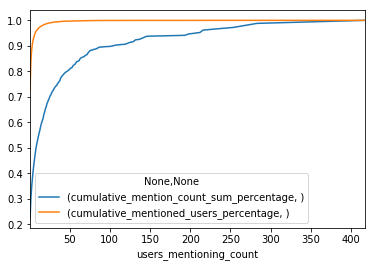

In [19]:
%matplotlib inline
mention_grouped_by_users_mentioning_df[['cumulative_mention_count_sum_percentage', 'cumulative_mentioned_users_percentage']].plot()

## Cut off the tail.
Removes users that were only mentioned by 1 user.

In [20]:
mention_summary_df.drop(mention_summary_df[mention_summary_df.users_mentioning_count == 1].index, inplace=True)
mention_summary_df['mention_screen_name'].count()

9317

## Approach 1: By mention count

### Top accounts (by mention count)
Unknown for type indicates that it is not matched with an known Twitter account.

In [21]:
mention_summary_df.sort_values('mention_count', ascending=False).head(50)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
51241574,2286,AP,media,146,0.080352
25073877,2252,realDonaldTrump,politicians,417,0.229499
822215679726100480,2114,POTUS,politicians,283,0.155751
818927131883356161,1999,PressSec,politicians,254,0.139791
3108351,1802,WSJ,media,216,0.118877
15754281,1429,USATODAY,media,132,0.072647
459277523,1122,BloombergBNA,media,54,0.029719
18916432,1095,SpeakerRyan,politicians,212,0.116676
18956073,1032,dcexaminer,media,63,0.034673


### Account types (by mention count)

In [22]:
types_by_mention_count_df = mention_summary_df[['type', 'mention_count']].groupby('type').sum()
types_by_mention_count_df['type_percentage']= types_by_mention_count_df['mention_count'] / types_by_mention_count_df['mention_count'].sum()
types_by_mention_count_df.sort_values('mention_count', ascending=False)

,mention_count,type_percentage
type,,
journalists,53755,0.366713
media,32091,0.218923
politicians,21226,0.144802
unknown,19714,0.134488
government,3860,0.026333
pundit,3445,0.023502
other_political,2850,0.019443
ngo,2661,0.018153
academic,1880,0.012825


## Approach 2: Per user
Mentions by type per user.

### Add type by merging screen name lookup

In [23]:
mention_all_join_df = pd.merge(mention_df, user_type_lookup_df[['type']], how='left', left_on='mention_user_id', right_index=True)
mention_all_join_df['type'].fillna('unknown', inplace=True)
# Drop tail
mention_all_join_limited_df = mention_all_join_df[mention_all_join_df.mention_user_id.isin(mention_summary_df.index)]
mention_all_join_limited_df.head()

,tweet_id,user_id,screen_name,mention_user_id,mention_screen_name,tweet_created_at,type
0,847428582821449730,780221130,loren_duggan,140286364,nielslesniewski,2017-03-30 12:41:33+00:00,journalists
2,845466584625885184,285772181,akesslerdc,17178161,JamesVGrimaldi,2017-03-25 02:45:16+00:00,journalists
3,845377611165552640,285772181,akesslerdc,25073877,realDonaldTrump,2017-03-24 20:51:43+00:00,politicians
4,845376332011913217,285772181,akesslerdc,822215679726100480,POTUS,2017-03-24 20:46:38+00:00,politicians
5,847843766601953280,29607664,adamliptak,218276360,mattfleg,2017-03-31 16:11:20+00:00,journalists


In [24]:
mention_summary_by_user_df = mention_all_join_limited_df.groupby([mention_all_join_limited_df.user_id, mention_all_join_limited_df.type]).size().unstack().fillna(0)
# Add a total column
mention_summary_by_user_df['total'] = mention_summary_by_user_df.sum(axis=1)
for col_name in mention_summary_by_user_df.columns[:-1]:
    mention_summary_by_user_df['{}_percent'.format(col_name)] = mention_summary_by_user_df[col_name] / mention_summary_by_user_df.total
mention_summary_by_user_df.head(10)

type,academic,business,cultural,foreign_political,government,journalists,media,ngo,other,other_political,...,foreign_political_percent,government_percent,journalists_percent,media_percent,ngo_percent,other_percent,other_political_percent,politicians_percent,pundit_percent,unknown_percent
user_id,,,,,,,,,,,,,,,,,,,,,
100165378,1.0,3.0,11.0,0.0,0.0,4.0,2.0,0.0,0.0,1.0,...,0.0,0.000000,0.114286,0.057143,0.000000,0.000000,0.028571,0.200000,0.000000,0.171429
1001991865,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
1002229862,0.0,0.0,0.0,0.0,4.0,15.0,3.0,1.0,0.0,0.0,...,0.0,0.129032,0.483871,0.096774,0.032258,0.000000,0.000000,0.064516,0.000000,0.193548
100802089,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,...,0.0,0.000000,0.250000,0.375000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000
100860790,0.0,0.0,2.0,0.0,0.0,37.0,10.0,3.0,0.0,0.0,...,0.0,0.000000,0.521127,0.140845,0.042254,0.000000,0.000000,0.028169,0.000000,0.239437
1009749229,2.0,0.0,0.0,0.0,3.0,40.0,35.0,10.0,0.0,0.0,...,0.0,0.029703,0.396040,0.346535,0.099010,0.000000,0.000000,0.000000,0.019802,0.089109
1013785220,0.0,0.0,0.0,0.0,0.0,5.0,16.0,0.0,0.0,0.0,...,0.0,0.000000,0.208333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
102171691,1.0,0.0,4.0,0.0,3.0,74.0,502.0,3.0,1.0,0.0,...,0.0,0.004687,0.115625,0.784375,0.004687,0.001563,0.000000,0.056250,0.001563,0.023438
102238997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.571429


### Average of percent of mentions by type for each user
That is, for each user determine the percent of mentions by type. Then take the average of each type.

Thus, this mention analysis is on a per-user basis, accounting for how prolific a tweeter a user is. (That is, users who tweet aren't weighed more heavily.)


In [25]:
mention_summary_by_user_df.filter(axis=1, regex="_percent$").mean()

type
academic_percent             0.010028
business_percent             0.022003
cultural_percent             0.011576
foreign_political_percent    0.002234
government_percent           0.032325
journalists_percent          0.306427
media_percent                0.277928
ngo_percent                  0.017977
other_percent                0.004198
other_political_percent      0.012168
politicians_percent          0.121569
pundit_percent               0.009235
unknown_percent              0.172333
dtype: float64

## Approach 3: By count of users mentioning
The number of users that mentioned an account. Thus, each user counts as 1, even if that user made multiple mentions of the account.

This weights an account that is mentioned by a 100 users more heavily than an account that is mentioned a 100 times by a single user.

In [26]:
mention_summary_df.sort_values('users_mentioning_count', ascending=False).head(20)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
25073877,2252,realDonaldTrump,politicians,417,0.229499
807095,862,nytimes,media,283,0.155751
822215679726100480,2114,POTUS,politicians,283,0.155751
818927131883356161,1999,PressSec,politicians,254,0.139791
3108351,1802,WSJ,media,216,0.118877
18916432,1095,SpeakerRyan,politicians,212,0.116676
759251,523,CNN,media,198,0.108971
2467791,475,washingtonpost,media,198,0.108971
9300262,664,politico,media,193,0.106219


### Account types (by count of users mentioning)

In [27]:
types_by_users_mentioning_df = mention_summary_df[['type', 'users_mentioning_count']].groupby('type').sum()
types_by_users_mentioning_df['type_percentage']= types_by_users_mentioning_df['users_mentioning_count'] / types_by_users_mentioning_df['users_mentioning_count'].sum()
types_by_users_mentioning_df.sort_values('users_mentioning_count', ascending=False)

,users_mentioning_count,type_percentage
type,,
journalists,24204,0.404364
unknown,12156,0.203084
politicians,7817,0.130595
media,7362,0.122993
government,1665,0.027816
other_political,1362,0.022754
ngo,1345,0.022470
pundit,1080,0.018043
business,899,0.015019


## Unknown accounts
Remember, the tail has been cut off

### Number of unknown accounts

In [28]:
 mention_summary_df[mention_summary_df.type == 'unknown'].count()

mention_count                  4796
mention_screen_name            4796
type                           4796
users_mentioning_count         4796
percent_of_users_mentioning    4796
dtype: int64

### Number of known accounts

In [29]:
 mention_summary_df[mention_summary_df.type != 'unknown'].count()

mention_count                  4521
mention_screen_name            4521
type                           4521
users_mentioning_count         4521
percent_of_users_mentioning    4521
dtype: int64

### Top unknown by mention count that are mentioned by at least 5 users

In [30]:
top_not_known_mention_df = mention_summary_df[(mention_summary_df.type == 'unknown') & (mention_summary_df.users_mentioning_count >= 5)].sort_values('mention_count', ascending=False)[['mention_screen_name', 'mention_count', 'users_mentioning_count']]
top_not_known_mention_df.head(50)

,mention_screen_name,mention_count,users_mentioning_count
user_id,,,
1173121356,xenocryptsite,16,5
50113613,oreillyfactor,13,12
18111042,michaelpfreeman,11,5
2178243152,AdvanceGuyNotes,11,6
1158638582,nypmetro,11,7
2353569672,ECOStates,11,7
23447403,Middlebury,10,5
3072098509,KoriSchake,10,6
315315368,MaxEhrenfreund,10,9


### Write top accounts to file

In [31]:
top_not_known_mention_df.to_csv('unknown_mentions.csv')